In [ ]:
import numpy as np
from scipy.sparse import csc_array,csr_array,diags_array
from scipy.sparse import random_array
import matplotlib.pyplot as plt
from scipy.special import expit
from numpy import logaddexp
from tqdm.auto import tqdm
from scipy.optimize import minimize_scalar
from scipy.sparse.linalg import spsolve
import qdldl
from scipy.sparse import block_array,eye_array
import scipy
from sparse_dot_mkl import dot_product_mkl
import time
from util import PrettyLogger,get_step_size,maxnorm,norm2

In [2]:
class LogisticNLL:
    def __init__(self, y, w):
        """
        y: array-like of binary responses (0 or 1)
        w: array-like of corresponding weights
        """
        self.y = np.array(y, dtype=float)
        self.w = np.array(w, dtype=float)

    def f(self, z):
        """
        Computes the negative weighted logistic log-likelihood:
            sum_i w_i [ log(1 + exp(z_i)) - y_i * z_i ]
        """
        z = np.array(z, dtype=float)
        return np.sum(self.w * (logaddexp(0, z) - self.y * z))

    def d1f(self, z):
        """
        Computes the first derivative (gradient) w.r.t. z:
            w_i [ sigma(z_i) - y_i ]
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        return self.w * (sig_z - self.y)

    def d2f(self, z):
        """
        Computes the second derivative (Hessian diagonal) w.r.t. z:
            w_i * sigma(z_i) * (1 - sigma(z_i))
        also using expit(z) for numerical stability.
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        hess_diag = self.w * sig_z * (1.0 - sig_z)
        return hess_diag

    def __call__(self, z):
        """
        By defining __call__, this object can be used like a function:
            phi(z) = phi.f(z)
        """
        return self.f(z)

In [3]:
from scipy.stats import Uniform


m = 10000
n = 500
samp = Uniform(a = -0.5,b = 0.5).sample


A = random_array((m,n),density = 0.01,data_sampler = lambda size:samp(size))
x_true = np.random.uniform(-0.1,1,n)

z_true = A@x_true

w = 100*np.ones(m)
y = np.random.binomial(w.astype(int),expit(z_true))/w

Q = 1.*diags_array(np.ones(n))

rng = np.random.default_rng(10)

xx = rng.normal(size = n)
samp = Uniform(a = -0.5,b = 0.5).sample

C = random_array((200,n),
                 density = 0.2,rng = rng)



In [4]:
c = C@xx + 0.01
Q = 1e-7*diags_array(np.ones(n))
f = LogisticNLL(y,w)

In [ ]:
from dataclasses import dataclass

@dataclass
class SolverSettings():
    max_precenter = 100
    max_iter = 200
    tol = 1e-7
    boundary_frac = 0.99
    gamma = 0.5
    min_mu = 1e-10
    tau_reg =1e-12
    init_merit_penalty =1000.
    verbose = True


class GLMProblem():
    def __init__(
        self,
        f,A,Q,C,c,
        b=None,
        settings = None
        ):
        if settings is None:
            settings = SolverSettings()
        

        self.settings = settings
        
        m = A.shape[0]
        n = A.shape[1]
        assert A.shape[1] == C.shape[1]
        A = csc_array(A)

        #TODO:Separate solver dispatch for unconstrained
        assert C.shape[0] == len(c)
        C = csc_array(C)
        k = C.shape[0]
        self.k = k
        self.c = c

        if b is None:
            b = np.zeros(n)
        self.b = b
        
        
        if settings.verbose is True:
            print(f"{k} constraints")
            print(f"{n} variables")
            print(f"{m} rows in A")
        self.f = f
        self.A = A
        self.Q = Q
        self.C = C
        self.m = m
        self.n = n
        self.In = csc_array(eye_array(n))
        self.Ik = csc_array(eye_array(k))
    
    def initialize(self,x0=None,y0 = None,s0 = None):
        if x0 is None:
            x = np.zeros(self.n)
        else:
            x = np.copy(x0)
        
        if y0 is None:
            y = np.ones(self.k)
        else:
            y = np.copy(y0)
            assert np.min(y)>1e-8
        
        if s0 is None:
            s = np.maximum(self.c - self.C@x,1.)
        else:
            s = np.copy(s0)
        
        return x,y,s
    
    def KKT_res(self,x,g,y,s,mu):
        rx = g + self.C.T@y - self.b
        rp = self.C@x + s - self.c
        rc = y * s - mu
        return rx,rp,rc
    
    def solve_KKT(
        self,
        x,y,s,H,rx,rp,rc,mu,#mu,x unused for now
        solver = None):
        #Nesterov-Todd scaling
        # Quasi definite for inequality constraints, 
        # "normal equations" Hessian for GLM part
        w = np.sqrt(y/s)
        wC = self.C.multiply(w[:,None])
        #Including tiny tau-shift here
        #later may want separate matrix,
        #larger tau shift + iterative refine
        G = block_array(
            [
                [H+self.settings.tau_reg*self.In,wC.T],
                [wC,-self.Ik]
            ],format = 'csc'
        )
        rhs = np.hstack([-rx,-w*rp + (w/y) * rc])
        if solver is None:
            solver = qdldl.Solver(G)
        else:
            solver.update(G)
        sol = solver.solve(rhs)
        # linres = rhs - G@sol
        dx = sol[:self.n]
        dy = w*sol[self.n:]
        ds = -rp - self.C@dx
        return dx,ds,dy,solver
    
    def get_H(self,z):
        D = self.f.d2f(z)[:,None]
        AtDa = dot_product_mkl(self.A.T,csc_array(self.A.multiply(D)))
        return AtDa + self.Q
    
    def solve(
        self,
        x0=None,
        y0=None,
        s0=None
        ):
        x,y,s = self.initialize(x0,y0,s0)
        logger = PrettyLogger()
        settings = self.settings
        merit_penalty = settings.init_merit_penalty
        start = time.time()
        
        def merit(x,y,s,mu,beta):
            fval = self.f(self.A@x)
            reg = (1/2) * x.T@self.Q@x
            barrier = -mu*np.sum(np.log(s))
            cons_vio = norm2(C@x +s - c))
            return fval + reg + barrier + beta * cons_vio,fval,cons_vio
    
        mu = 100.

        z = self.A@x
        H = self.get_H(z)
        gradf = self.A.T@self.f.d1f(z) + self.Q@x
        rx,rp,rc = self.KKT_res(x,gradf,y,s,mu)
        kkt_res = np.max(
                np.abs(np.hstack([rx,rp,rc+ mu]))#broadcasted (+mu), get r
            )
            

        
        solver = None    
        for i in range(settings.max_iter):
            if kkt_res<=settings.tol:
                break
            dx,ds,dy,solver = self.solve_KKT(x,y,s,H,rx,rp,rc,mu,solver)
            tmax = get_step_size(s,ds,y,dy,frac = settings.boundary_frac)
            m0,f0,cons2 = merit(x,y,s,mu,merit_penalty)
            t = tmax
            for linesearch_step in range(10):
                mt,ft,cons2t = merit(x+t*dx,y+t*dy,s+t*ds,mu,merit_penalty)
                if mt<m0:
                    break
                else:
                    t = 0.9*t
            x = x + t*dx
            s = s + t*ds
            y = y + t*dy
            z = self.A@x
            H = self.get_H(z)
            gradf = self.A.T@self.f.d1f(z) + self.Q@x

            if kkt_res<=100 * mu:
                mu_est = np.dot(s,y)/self.k
                xi = np.min(s*y)/mu_est
                mu_lower = np.maximum(mu*0.01,settings.min_mu)
                mu = np.maximum(
                    mu_lower,
                    settings.gamma * 
                    np.minimum(
                    (1-settings.boundary_frac)*(1-xi)/xi + 0.1,2)**3 * mu_est
                    )
                        
            rx,new_rp,rc = self.KKT_res(x,gradf,y,s,mu)
            if maxnorm(new_rp)>1e-8 and np.linalg.norm(new_rp)>0.95*np.linalg.norm(rp):
                merit_penalty = 20*merit_penalty

            rp = new_rp
            kkt_res = np.max(
                np.abs(np.hstack([rx,rp,rc+ mu]))#broadcasted (+mu), get r
            )
            elapsed = time.time() - start
            logger.log(
                iter=i+1,
                primal = ft,
                cons_viol = maxnorm(rp),
                mu=mu,
                merit_pen=merit_penalty,
                Δx = maxnorm(t*dx),
                Δmerit=mt - m0,
                step=t,
                KKT_res=kkt_res,
                cum_time=elapsed,
            )
        return x,logger.to_dataframe()


In [6]:
%load_ext line_profiler

In [331]:
n = 1
A = csc_array(diags_array(np.ones(n)))
C = -1*csc_array(diags_array(np.ones(n)))

Q = 0. *csc_array(diags_array(np.ones(n)))
b = -2*np.ones(n)

w = 100000.*np.ones(n)
y = 0.*np.ones(n)

c = -1000*np.ones(n)
f = LogisticNLL(y,w)
problem = GLMProblem(f,A,Q,C,c,b = b)

self = problem

x,y,s = self.initialize(x0 = -4.5 * np.ones(n),s0 = np.ones(n))

1 constraints
1 variables
1 rows in A


In [332]:
f.d1f(A@x)

array([1098.69426306])

In [355]:
mu = 1e4
z = self.A@x
H = self.get_H(z)
gradf = self.A.T@self.f.d1f(z) + self.Q@x
rx,rp,rc = self.KKT_res(x,gradf,y,s,mu)
kkt_res = np.max(
        np.abs(np.hstack([rx,rp,rc+ mu]))#broadcasted (+mu), get r
    )
solver = None

dx,ds,dy,solver = self.solve_KKT(x,y,s,H,rx,rp,rc,mu,solver)
tmax = get_step_size(s,ds,y,dy,frac = 0.99)


In [ ]:
#Demonstrate necessity of modified merit + linesearch

def merit(x,s,beta,mu):
    fval = self.f(self.A@x)
    reg = (1/2) * x.T@self.Q@x
    barrier = -mu*np.sum(np.log(s))
    cons_vio = np.sum((C@x +s - c)**2)
    return fval + reg + barrier + beta * cons_vio

def gradmerit(x,s,beta,mu):
    z = self.A@x
    rp = self.C@x +s - c
    gxf = self.A.T@self.f.d1f(z) - b + self.Q@x
    gsf = -mu/s

    gxC = beta * C.T@rp
    gsC = beta * rp
    return gxf,gsf,gxC,gsC



beta = 1.
gxf,gsf,gxC,gsC = gradmerit(x,s,beta,mu)

desc_f = np.dot(dx,gxf) + np.dot(ds,gsf)
desc_C = np.dot(dx,gxC) + np.dot(ds,gsC)

print(desc_f)
print(desc_C)

tot  = desc_f + desc_C
cosangle = tot / (
    np.sqrt(np.sum((gxf + gxC)**2 + np.sum((gsf+gsC)**2)))
    *np.sqrt((np.sum(dx**2)+np.sum(ds**2)))
    )

print("direction dot grad merit", tot)
print("cos of angle", cosangle)
print("Not a descent direction")

9973955.468237383
-1011030.25
direction dot grad merit 8962925.218237383
cos of angle 0.9999989579171634
Not a descent direction


In [ ]:
armijo_rat = 0.05
max_beta_mul = 100
max_linesearch = 10

x_gf = gradf - b
s_gf = -mu/s

x_gpen = C.T@rp
s_gpen = rp

fdec = np.dot(x_gf, dx) + np.dot(s_gf,ds)
pen_dec = np.dot(x_gpen,dx) + np.dot(s_gpen,ds)

if fdec + beta * pen_dec > 0:
    #Force descent direction on merit
    beta = 2  * fdec/pen_dec

dz = A@dx
t = tmax

local_curv = np.dot(dz,f.d2f(z)*dz) + mu * np.dot(ds/s,ds/s)

oldf = f(z) + (1/2) * x.T@Q@x - np.dot(b,x) - mu * np.log(s)
old_penval = norm2(rp)

def eval_line(t):
    xstep = x + t* dx
    sstep = s + t* ds
    newf = f(z + t * dz) + (1/2) * (xstep).T@Q@(xstep) - np.dot(b,(xstep)) - mu * np.log(sstep)
    new_penval = norm2(C@(xstep) + sstep - c)
    return newf,new_penval
newf,new_penval = eval_line(t)

#if doesn't satisfy armijo on merit fun
if newf + beta * new_penval > oldf + beta * old_penval + t * armijo_rat * (fdec + beta * pen_dec):
    accepted = False
    #Try to increase penalty to accept step if we're infeasible
    if maxnorm(rp)>1e-10:
        #Check if we can make it satisfy by increasing beta
        beta_new = ((newf - oldf) - armijo_rat*t * (fdec + beta * pen_dec))/(new_penval - old_penval)
        if beta_new<= max_beta_mul * beta:
            beta = beta_new
            accepted = True
        else:
            beta = max_beta_mul * beta
    if accepted ==False:
        #proceed to a linesearch
        for ls in max_linesearch:
            t = 0.8 * t
            newf = (
                f(z + t * dz)
                + (1/2) * (x + t*dx).T@Q@(x + t *dx)
                - np.dot(b,(x+t*dx))
                - mu * np.log(s + t* ds)
            )
            new_penval = norm2(C@(x+t * dx) + s + t*ds - c)
            if newf + beta * new_penval < oldf + beta * old_penval + t * armijo_rat * (fdec + beta * pen_dec):
                accepted = True
                break
    if accepted ==False:
        print("Line search failed")






print(tmax*fdec)
print(tmax*pen_dec)



9909.959527819768
-1004.54317154397


In [368]:
fdec + beta*pen_dec


8962925.218237383

In [ ]:

beta = 1.
gxf,gsf,gxC,gsC = gradmerit(x,s,beta,mu)

desc_f = np.dot(dx,gxf) + np.dot(ds,gsf)
desc_C = np.dot(dx,gxC) + np.dot(ds,gsC)

print(desc_f)
print(desc_C)

tot  = desc_f + desc_C
cosangle = tot / (np.sum(gxf**2 + gxC**2))

print(tot)
print(cosangle)

990.0160577582284
-122.5
867.5160577582284
7.074792155274012


In [98]:
%lprun -f problem.solve problem.solve()

# x,hist = problem.solve()

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ iter │   primal   │ cons_viol  │    mu    │ merit_pen │  Δmerit   │    Δx     │  step  │  KKT_res  │ cum_time │
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│    1 │ 1.2488e+04 │ 0.0000e+00 │  1.0e+00 │  1.00e+03 │ -6.75e+04 │  2.03e+00 │  1.000 │  1.24e+03 │     0.02s │
│    2 │ 6.5896e+03 │ 0.0000e+00 │  1.0e+00 │  1.00e+03 │ -5.88e+03 │  6.95e-01 │  0.651 │  6.00e+02 │     0.03s │
│    3 │ 2.7005e+03 │ 0.0000e+00 │  1.0e+00 │  1.00e+03 │ -3.86e+03 │  1.02e+00 │  0.979 │  2.16e+02 │     0.04s │
│    4 │ 1.3684e+03 │ 0.0000e+00 │  1.0e+00 │  1.00e+03 │ -1.29e+03 │  9.59e-01 │  1.000 │  7.49e+01 │     0.05s │
│    5 │ 9.4469e+02 │ 0.0000e+00 │  1.0e-02 │  1.00e+03 │ -3.83e+02 │  8.35e-01 │  1.000 │  2.36e+01 │     0.06s │
│    6 │ 8.3714e+02 │ 0.0000e+00 │  1.0e-02 │  1.00e+03 │ -7.67e+01 │  5.31e-01 │  

Timer unit: 1e-09 s

Total time: 0.152713 s
File: /tmp/ipykernel_3189394/4111137327.py
Function: solve at line 119

Line #      Hits         Time  Per Hit   % Time  Line Contents
   119                                               def solve(
   120                                                   self,
   121                                                   x0=None,
   122                                                   y0=None,
   123                                                   s0=None
   124                                                   ):
   125         1     167466.0 167466.0      0.1          x,y,s = self.initialize(x0,y0,s0)
   126         1      53902.0  53902.0      0.0          logger = PrettyLogger()
   127         1        372.0    372.0      0.0          settings = self.settings
   128         1        561.0    561.0      0.0          merit_penalty = settings.init_merit_penalty
   129                                           
   130         1        695.0   

In [14]:
hist

,iter,primal,cons_viol,mu,merit_pen,Δmerit,Δx,step,KKT_res,cum_time
0,1,7.928566e+07,5.688949e+00,1.000000e+02,1000.0,-8.287980e+05,2.242128e+00,0.656100,1.063005e+05,1.606940
1,2,7.194888e+07,4.796163e-14,1.000000e+02,1000.0,-8.741679e+06,9.679450e-01,1.000000,2.423174e+04,2.294987
2,3,7.075995e+07,2.664535e-14,1.000000e+02,1000.0,-1.175076e+06,2.787518e-01,0.716806,9.987745e+03,2.995758
3,4,7.046926e+07,1.953993e-14,1.239151e+04,1000.0,-2.822718e+05,1.468117e-01,0.480497,5.794272e+03,3.668431
4,5,7.144471e+07,2.842171e-14,8.948833e+03,1000.0,-1.234304e+06,4.447473e-01,0.745617,2.722485e+04,4.334414
5,6,7.133122e+07,3.019807e-14,8.948833e+01,1000.0,-3.523316e+04,2.435896e-01,1.000000,1.970115e+04,5.026636
6,7,7.050653e+07,1.776357e-14,8.948833e+01,1000.0,-8.116199e+05,2.110036e-01,0.690656,4.128200e+03,5.716642
7,8,7.032046e+07,1.243450e-14,6.040555e+02,1000.0,-1.772955e+05,1.488795e-01,0.550418,2.179858e+03,6.450219
8,9,7.025529e+07,1.421085e-14,6.040555e+00,1000.0,-3.589942e+04,1.629589e-01,1.000000,8.879796e+02,7.136289
9,10,7.021588e+07,1.421085e-14,6.040555e+00,1000.0,-3.869596e+04,9.497203e-02,0.750680,3.348675e+02,7.813364


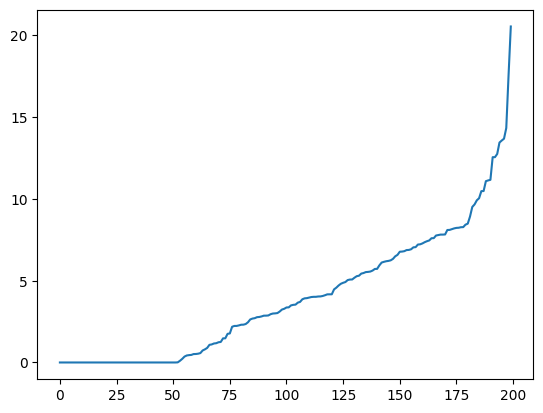

In [15]:
plt.plot(np.sort(c - C@x))

In [ ]:
import cvxpy as cp
n = A.shape[1]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
neg_log_likelihood = cp.sum(
    cp.multiply(w,cp.logistic(A @ beta)- cp.multiply(y, A @ beta))
)
regularization = beta.T@Q@beta/2

problem  = cp.Problem(cp.Minimize(
    (neg_log_likelihood + regularization)),[C @ beta <= c]
)
problem.solve(verbose = True)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Apr 17 08:54:43 PM: Your problem has 500 variables, 200 constraints, and 0 parameters.
(CVXPY) Apr 17 08:54:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 08:54:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 08:54:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 08:54:43 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 08:54:43 PM: Compiling problem (target solver=CLARABEL

In [138]:
print(f(A@x) + (1/2) *x.T@Q@x)

cvx_x = beta.value
print(f(A@cvx_x) + (1/2) *cvx_x.T@Q@cvx_x)

68542.6735196966
68542.67355710643


In [22]:
cvx_x - x

array([ 1.88304223e-06,  6.61183275e-06,  1.96638301e-06, -4.12074586e-08,
       -6.02499955e-06,  1.10058918e-06, -6.10930961e-07, -1.26946839e-06,
        5.88587145e-07,  6.00444789e-07, -1.00792179e-08,  2.13289630e-06,
       -1.92164394e-06,  1.98446058e-06, -4.71918464e-06,  2.48029504e-06,
       -8.10489266e-07,  7.49122216e-06,  2.10166768e-06, -2.29564910e-06,
        1.44871601e-07, -2.89828361e-06, -5.15847388e-06,  9.14257737e-07,
       -1.74684648e-06,  1.02833231e-06, -1.56754350e-05, -5.31380687e-07,
        5.18384500e-07, -3.40708443e-07,  4.43635682e-06,  1.30159259e-06,
       -3.78598153e-06,  2.37993245e-07,  5.00879387e-07,  5.31418336e-07,
       -1.72539662e-06, -1.81282658e-06, -2.21485332e-06, -2.74029104e-06,
       -3.99108030e-06,  1.21493751e-06,  6.06727824e-08,  1.36522697e-06,
        5.72811232e-07,  2.98111301e-06,  1.10734558e-07, -3.51312001e-06,
       -2.34090067e-06, -7.99061721e-07, -1.09719711e-06,  4.94875204e-07,
       -2.65096531e-06,  

In [177]:
print(problem.value -f(A@x) - (1/2) *x.T@Q@x)

-6.8239253430135705e-06
